# Продуктовый анализ обучающего приложения

<b> Описание работы </b>

Исследование активности пользователей в обучающем игровом приложении. Ученики получают уровни по мере прохождения материала курса, также они могут совершать покупки.

В рамках анализа нужно рассчитать следующие метрики:
- Retention и время, которое ученики проводят в приложении. Как ученики переходят с уровня на уровень;
- Метрики монетизации для всей когорты;
- Где ученики совершают больше всего платежей;
- Где ученики совершают первые платежи.

**Датасеты:**

<b> Пользователи - users: </b>
- <i> id пользователя (user_id) </i>
- <i> время события (reg_time) </i>

<b> Сессии - sessions: </b>
- <i> id пользователя (user_id) </i>
- <i> время начала сессии (open_time) </i>
- <i> время окончания сессии (close_time) </i>

<b> Платежи - payments: </b>
- <i> id пользователя (user_id) </i>
- <i> время события (time) </i>
- <i> сумма платежа (amt) </i>

<b> Уровни - levels: </b>
- <i> id пользователя (user_id) </i>
- <i> время события (time) </i>
- <i> номер полученного игроком уровня (level) </i>

### Загрузка и предобработка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime as dt
from plotly import graph_objects as go
import plotly.express as px
import seaborn as sns
    
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter("ignore")

In [2]:
# загрузка таблиц
try:
    users, sessions, payments, levels = (
        pd.read_csv('users.csv'),       # пользователи
        pd.read_csv('sessions.csv'),    # сессии
        pd.read_csv('payments.csv'),    # платежи
        pd.read_csv('levels.csv'),      # уровни
    )

except:
    users, sessions, payments, levels = (
        pd.read_csv('https://.../users.csv'),
        pd.read_csv('https://.../sessions.csv'),
        pd.read_csv('https://.../payments.csv'),
        pd.read_csv('https://.../levels.csv')
    )

In [3]:
for i in [users, sessions, payments, levels]:
    print(i.info())
    print('Кол-во дубликатов:', i.duplicated().sum())
    print('Пустые ячейки:\n', i.isna().sum().sort_values(ascending=False))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31114 entries, 0 to 31113
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31114 non-null  int64 
 1   user_id     31114 non-null  int64 
 2   reg_time    31114 non-null  object
dtypes: int64(2), object(1)
memory usage: 729.4+ KB
None
Кол-во дубликатов: 0
Пустые ячейки:
 Unnamed: 0    0
user_id       0
reg_time      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358004 entries, 0 to 358003
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  358004 non-null  int64 
 1   user_id     358004 non-null  int64 
 2   close_time  358004 non-null  object
 3   open_time   358004 non-null  object
dtypes: int64(2), object(2)
memory usage: 10.9+ MB
None
Кол-во дубликатов: 0
Пустые ячейки:
 Unnamed: 0    0
user_id       0
close_time    0
open_time     0
dtype: int64

<class 'p

- Нет ни пустых ячеек, ни дубликатов;
- Учитывая разные user_id, можно утверждать, что неявные дубликаты тоже отсутствуют;
- Первый столбец каждого датафрейма дублируется с индексом, удалю его;
- Также нужно будет поменять формат даты в каждой таблице.

In [4]:
# уберу столбец индексов
users = users.iloc[:, 1:]
sessions = sessions.iloc[:, 1:]
payments = payments.iloc[:, 1:]
levels = levels.iloc[:, 1:]

In [5]:
# смена формата даты в датафреймах

# пользователи
users['reg_time'] = pd.to_datetime(users['reg_time'])
users['reg_date'] = pd.to_datetime(users['reg_time']).dt.date

# сессии
sessions['close_time'] = pd.to_datetime(sessions['close_time'])
sessions['open_time'] = pd.to_datetime(sessions['open_time'])
sessions['open_date'] = pd.to_datetime(sessions['open_time']).dt.date
sessions['close_date'] = pd.to_datetime(sessions['open_time']).dt.date

# платежи
payments['pay_time'] = pd.to_datetime(payments['pay_time'])
payments['pay_date'] = pd.to_datetime(payments['pay_time']).dt.date

# уровни
levels['time'] = pd.to_datetime(levels['time'])
levels['level_date'] = pd.to_datetime(levels['time']).dt.date

In [6]:
# уникальные значения уровней
levels['level'].unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21.])

In [7]:
# значения уровней целые - поменяю формат на integer
levels['level'] = levels['level'].astype(int)

Датафреймы были загружены и обработаны: дубликаты и пропуски не обнаружены, были изменены форматы данных (даты и уровни), удален столбец с индексом. Данные готовы к работе!

### Анализ данных

In [8]:
# временные рамки регистраций пользователей
reg_time_min = users['reg_date'].min() # минимальная дата
reg_time_max = users['reg_date'].max() # максимальная дата

print('Период регистрации пользователей от', reg_time_min, 'до', reg_time_max)

Период регистрации пользователей от 2023-05-11 до 2023-05-21


In [9]:
# временные рамки сессий
sessions_min = sessions['open_date'].min()
sessions_max = sessions['close_date'].max()

print('Период сессий от', sessions_min, 'до', sessions_max)

Период сессий от 2023-05-11 до 2023-05-30


In [10]:
# временные рамки оплат
payments_min = payments['pay_date'].min()
payments_max = payments['pay_date'].max()

print('Период оплат от', payments_min, 'до', payments_max)

Период оплат от 2023-05-12 до 2023-05-30


In [11]:
# временные рамки получения уровней
levels_min = levels['level_date'].min()
levels_max = levels['level_date'].max()

print('Период получения уровней от', levels_min, 'до', levels_max)

Период получения уровней от 2023-05-11 до 2023-05-30


В датафреймы входят пользователи, зарегистрированные с 11 по 21 мая 2023 и совершавшие действия с 11 по 30 мая 2023. Возьмем их в одну когорту и будем считать горизонт анализа - 10 дней с момента регистрации.

#### Retention и время, которое ученики проводят в приложении

In [12]:
# дата наблюдения
observation_date = datetime(2023, 6, 1).date()
# горизонт анализа
horizon = 10

In [13]:
def get_profiles(sessions, payments, users):
    
    # параметры первых посещений
    profiles = (
    sessions.sort_values(by=['user_id','open_time']).groupby(['user_id'])
    .agg({'open_time': 'first'})
    .rename(columns={'open_time': 'first_ts'})
    .reset_index()
    )
    
    # дата первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(payments['user_id'].unique())
    
    # объединение profiles и users
    profiles = (
    profiles.merge(users, on='user_id', how='left').sort_values(by='reg_time')
    )
    
    return profiles

In [14]:
# создание профилей
profiles = get_profiles(sessions, payments, users)
profiles.head()

,user_id,first_ts,dt,month,payer,reg_time,reg_date
9134,289291,2023-05-11 02:01:37,2023-05-11,2023-05-01,False,2023-05-11 02:01:36.784,2023-05-11
14212,453630,2023-05-11 02:04:02,2023-05-11,2023-05-01,False,2023-05-11 02:04:01.513,2023-05-11
27032,868816,2023-05-11 02:06:19,2023-05-11,2023-05-01,False,2023-05-11 02:06:19.171,2023-05-11
14652,467925,2023-05-11 02:08:40,2023-05-11,2023-05-01,False,2023-05-11 02:08:40.094,2023-05-11
19980,639160,2023-05-11 02:10:23,2023-05-11,2023-05-01,False,2023-05-11 02:10:22.682,2023-05-11


In [15]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключение пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'open_time']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['open_time'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # таблица удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # таблица динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возврат обеих таблиц и сырых данных
    return result_raw, result_grouped, result_in_time 

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # размер сетки для графиков
    plt.figure(figsize=(10, 5))

    # исключаю размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавление второго признака — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # кривые удержания платящих пользователей
    ax1 = plt.subplot(1, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')


    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    plt.tight_layout()
    plt.show() 

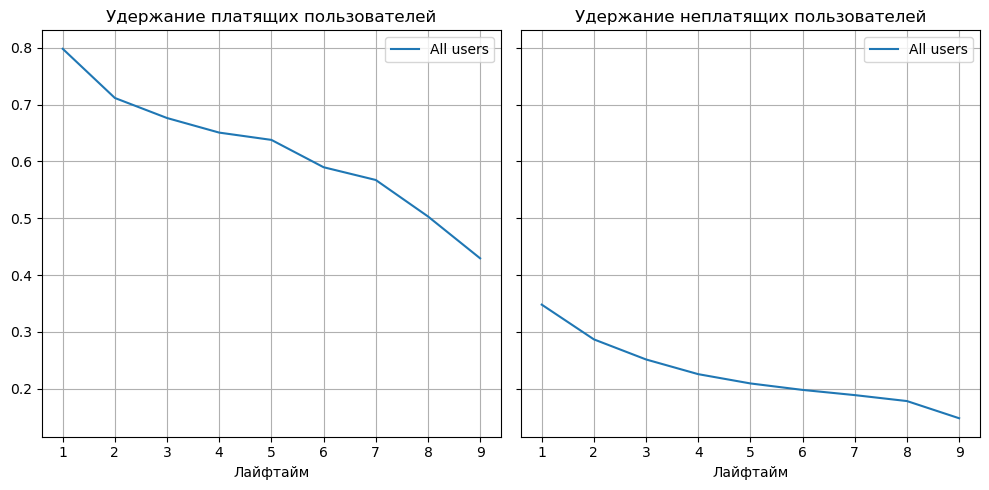

In [18]:
# удержание
retention_raw, retention, retention_history = get_retention(
    profiles, sessions, observation_date, horizon
)

plot_retention(retention, retention_history, horizon) 

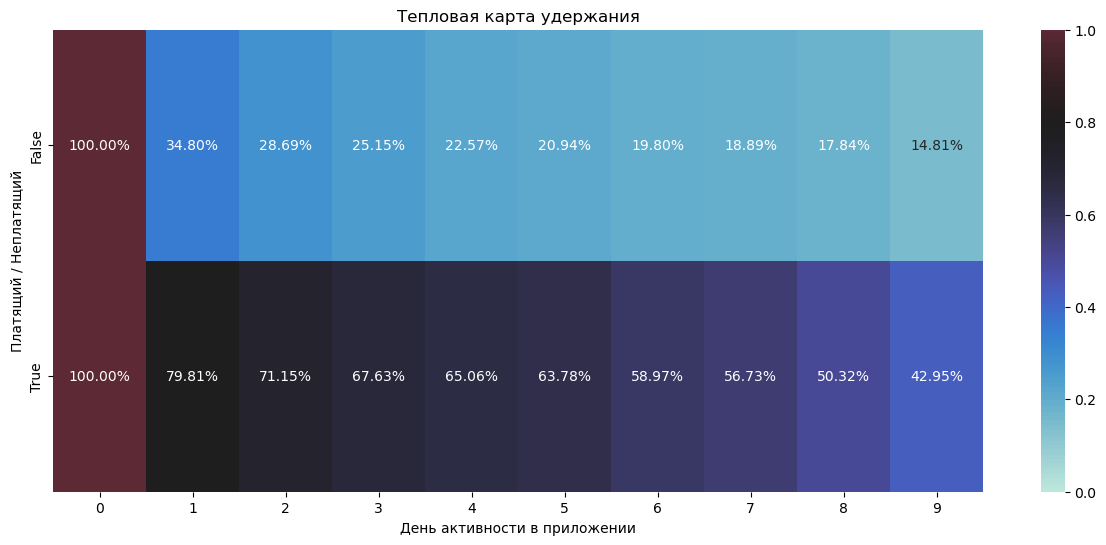

In [19]:
plt.figure(figsize = (15, 6))
sns.heatmap(retention.drop(columns = ['cohort_size']),
    annot = True,
    fmt = '.2%',
    vmin = 0,
    vmax = 1,
    center = 0.8
)
plt.xlabel('День активности в приложении')
plt.ylabel('Платящий / Неплатящий')
plt.title('Тепловая карта удержания')
plt.show()

Удержание платящих пользователей заметно выше, в первый день после регистрации возвращаются около 80%, на на 9 день - остается 43%. Неплатящие уступают - показатель удержания равномерно падает с 35% до 15% за первые 10 дней с момента регистрации.

<b> Предложения как улучшить удержание пользователей: </b>

- <i> показывать при включении, сколько дней подряд человек заходит в приложение (может быть, даже поощрения за внутреннюю валюту);
- <i> добавить соревнования между друзьями;
- <i> чаще напоминать об обучении (уведомления из приложения, письма на почту), но не навязчиво.

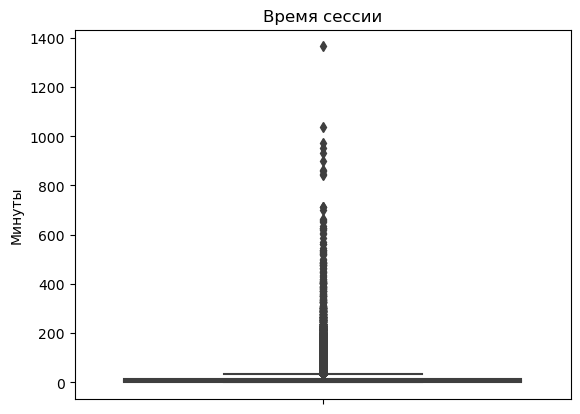

count    358004.000000
mean         12.510352
std          19.519455
min           0.000000
25%           2.600000
50%           6.983333
75%          15.333333
max        1365.266667
Name: delta_minutes, dtype: float64

In [20]:
# время, которое ученики проводят в приложении
sessions_new = sessions.copy()
sessions_new['delta'] = sessions_new['close_time'] - sessions_new['open_time']

# перевод продолжительности сессий в часы
sessions_new['delta_minutes'] = sessions_new['delta']/np.timedelta64(1, 'm')

# ящик с усами по месяцам
ax = sns.boxplot(y = "delta_minutes", data=sessions_new)

ax.set(ylabel='Минуты', title='Время сессии')
plt.show()

# описание распределения
sessions_new['delta_minutes'].describe()

Медиана продолжительности сессии равна 7 минут. Половина значений лежит в промежутке от 2,6 до 15,3 минут. Есть и выбросы свыше 500 минут (более 8 часов).

In [21]:
# 99 процентиль
np.percentile(sessions_new['delta_minutes'], 99)

81.93283333333287

Не более 1% сессий длятся дольше 74 минут или 1 часа 14 минут.
Не буду рассматривать сессии дольше этого времени.

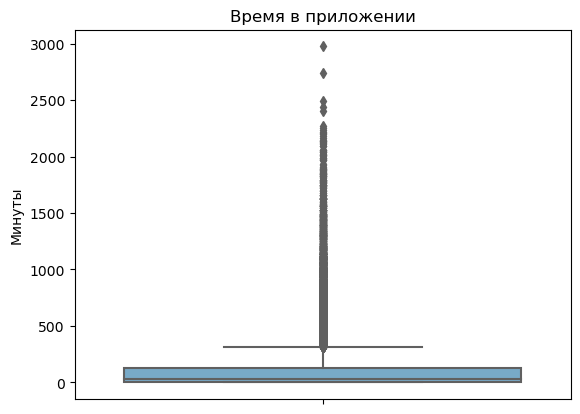

In [22]:
# время сессий больше 0 и не более 74 минут

sessions_new = sessions_new.query('0 < delta_minutes <= 74')

ses_time = sessions_new.groupby('user_id').agg(
    session_time=('delta_minutes', 'sum')).sort_values(by='session_time', ascending=False)

# ящик с усами
ax = sns.boxplot(y = "session_time", data=ses_time, palette="Blues")

ax.set(ylabel='Минуты', title='Время в приложении')
plt.show()

В среднем пользователи провели в приложении около 1 часа 12 минут, 50% из них - от 20 минут до 3 часов 27 минут. Максимум 8 часов 9 минут, есть выбросы. Пользователи проводят много времени в приложении.

#### Переход с уровня на уровень

Переходить с уровня на уровень пользователи начинают с момента регистрации, поэтому буду анализировать по всему периоду данных (11 - 30 мая 2023).

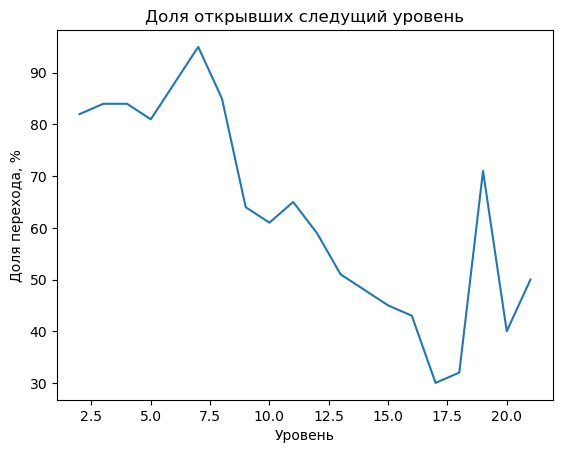

In [23]:
# активные пользователи
active_users = sessions['user_id'].nunique()

# количество пользователей на каждом уровне
levels_mode = levels.groupby('level').agg(
    level_count=('user_id', 'count'))
#display(levels_mode)

# доля поднявшихся на следующий уровень
for i in range(3, 22):
    levels_mode.loc[i, 'share, %'] = round(levels_mode.loc[i, 'level_count'] / levels_mode.loc[i-1, 'level_count']*100)

# доля поднявшихся на 2 уровень среди активных пользователей
levels_mode.loc[2, 'share, %'] = round(levels_mode.loc[2, 'level_count'] / active_users * 100)

# график

plt.plot(levels_mode.index, levels_mode['share, %'])
plt.xlabel('Уровень')
plt.ylabel('Доля перехода, %')
plt.title('Доля открывших следущий уровень')

plt.show() 

82% опльзователей переходят с первого уровня на второй. Можно отметить, что проблем с удержанием на этом этапе нет, хотя данный показатель стоит улучшать.

Доля пользователей, переходящих на следующий уровень снижается с 82% до 30% на 17 уровне, затем сложно оценивать тренды, ведь всего семеро пользователей дошли до 18 уровня. Пользователи легко переходят с 6 на 7 уровень (95%).

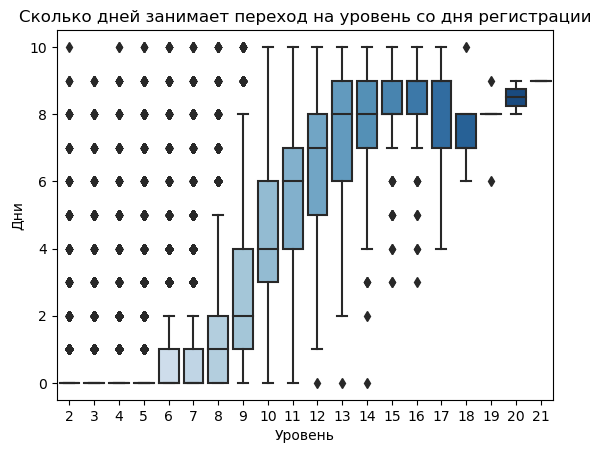

In [24]:
# для каждого уровня посчитаю количество дней, прошедшее от даты регистрации
# для этого объединю датафреймы уровни и пользователи
level_raw = levels.merge(
    users[['user_id', 'reg_date']], on='user_id', how='left'
)

# вычисляем время получения каждого уровня от регистрации в днях
level_raw['level_got'] = (
    level_raw['level_date'] - level_raw['reg_date']
).dt.days

# боксплот для каждого уровня
ax = sns.boxplot(x="level", y = "level_got", data=level_raw, palette="Blues")

ax.set(xlabel='Уровень', ylabel='Дни', title='Сколько дней занимает переход на уровень со дня регистрации')
plt.show()

Обычно уровни со 1 по 4 проходят в день регистрации, с 5 по 7 обычно на следующий день, на второй день после регистрации доходят до уровня 9. Уровень 10 открывают через 4 дня после регистрации, ур.11 - 6 дней, ур.12 - 7 дней, следующие уровни - более недели. Есть пользователи, открывшие второй уровень на 10 день после регистрации, а есть те, кто доходит до 12-14 уровня в день регистрации. Пользователи, поднявшиеся выше 15 уровня, потратили чуть больше недели.

#### Метрики монетизации для всей когорты

In [25]:
# доход за период
revenue = payments['amt'].sum()
print('Доход за период:', round(revenue, 2))

# пользователи за весь период
all_users = users['user_id'].nunique()
print('Пользователи за весь период:', all_users)

# платящие пользователи за весь период
all_pay_users = payments['user_id'].nunique()
print('Платящие пользователи за весь период:', all_pay_users)

# Средний чек
avg_bill = payments['amt'].median()
print('Средний чек: {:.2f}'.format(avg_bill)) 

# Average Revenue Per User
ARPU = round(revenue / all_users, 2)
print ('ARPU:', ARPU)

# Average Revenue Per Paying User
ARPPU = round(revenue / all_pay_users, 2)
print ('ARPPU:', ARPPU)

# Paying Share
PS = ARPU / ARPPU * 100
print ('Paying share: {:.2f}%'.format(PS))

Доход за период: 501.41
Пользователи за весь период: 31114
Платящие пользователи за весь период: 312
Средний чек: 0.40
ARPU: 0.02
ARPPU: 1.61
Paying share: 1.24%


In [26]:
# активные пользователи
active_users = sessions['user_id'].nunique()

# сколько людей платили больше одного раза
payers_more_one = payments.groupby('user_id').agg(
    pay_count=('pay_time', 'count')).query('pay_count > 1')['pay_count'].count()

# воронка категорий пользователей
# data = dict(
#    users_number=[all_users, active_users, all_pay_users, payers_more_one],
#    cluster=["Зарегистрированные пользователи", "Активные пользователи", "Платящие пользователи", "Платящие более 1 раза"])

#fig = px.funnel(
#    data,
#    x='users_number',
#    y='cluster',
#    color_discrete_sequence=px.colors.qualitative.Prism
#)

#fig.show()

,date,visitors,payers,share
0,2023-05-11,347,0.0,0.00
1,2023-05-12,566,3.0,0.53
2,2023-05-13,859,5.0,0.58
3,2023-05-14,1673,4.0,0.24
4,2023-05-15,4758,8.0,0.17
5,2023-05-16,10301,8.0,0.08
6,2023-05-17,11533,21.0,0.18
7,2023-05-18,12264,44.0,0.36
8,2023-05-19,9969,73.0,0.73
9,2023-05-20,9632,81.0,0.84


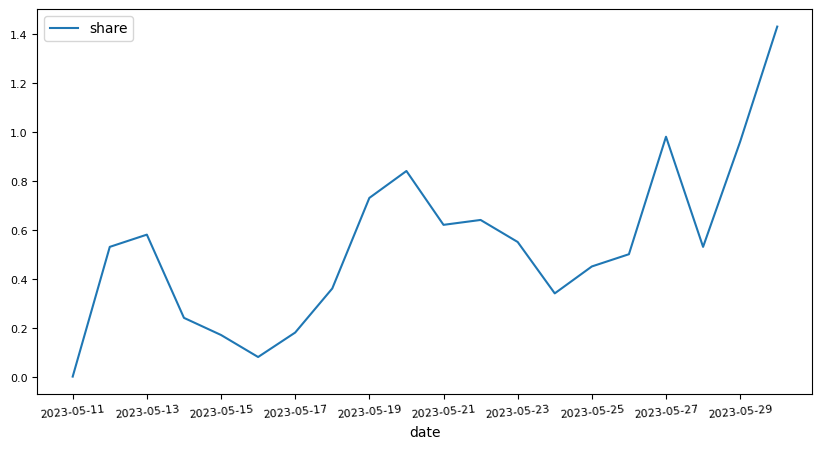

In [27]:
# платящие пользователи по дням
payers_by_date = payments.pivot_table(
    columns='pay_date', values='user_id', aggfunc='nunique'
).T.reset_index().rename(columns={'pay_date': 'date', 'user_id': 'payers'}) 

# количество активных пользователей по дням
visitors_by_date = sessions.pivot_table(
    columns='open_date', values='user_id', aggfunc='nunique'
).T.reset_index().rename(columns={'open_date': 'date', 'user_id': 'visitors'}) 

# доля платящих пользователей от посетителей по дням
result_table = visitors_by_date.merge(payers_by_date, on='date', how='left').fillna(0)
result_table['share'] = round(result_table['payers'] / result_table['visitors'] * 100, 2)

result_table.plot(x="date", y="share", kind="line", figsize=(10,5), rot=5, fontsize=8);

display(result_table)

В течение исследуемого периода наблюдается повышательный тренд по доле платящих пользователей от всех посетителей приложения: показатель растет с 0 до 1,4% - не слишком высокое значение.

<b> Выводы по метрикам монетизации: </b>
- доход сервиса за период составил 501,41
- из 31 114 зарегистрованных пользователей совершали оплату 312 (более 1%, что является низким показателем)
- доход на пользователя составил 0,02; на платящего - 1,61
- средний чек равен 0,4
- каждый третий платящий пользователь совершил более одной покупки (115 человек)
- количество ежедневно платящих пользователей растет до 20 мая (81 человек), затем сокращается наряду с падением посещений сервиса (от 49 до 2 за отчетный период), а их доля по дням растет с 0 до 1,4%

#### Где совершается больше всего платежей

Для ответа на данных вопрос предлагаю привязать платеж и открывшийся уровень (то есть использование платежа в качестве буста для продолжения учебы). Можно было бы привязать платеж и день пользования, но, как показал анализ выше, люди проходят уровни в разном темпе.

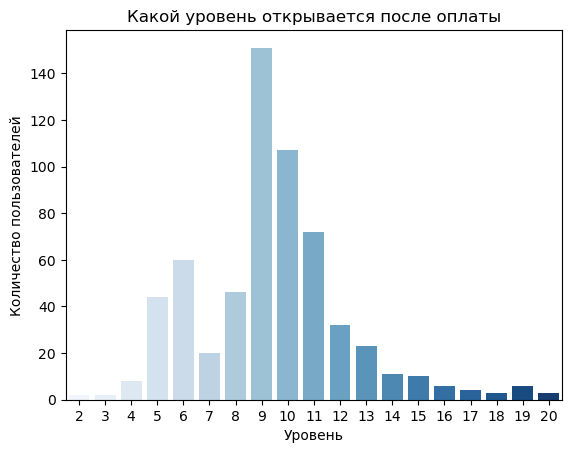

In [28]:
# посчитаю, какой уровень был открыт после оплаты
pay_level_raw = payments.merge(
    levels[['user_id', 'level', 'time']], on='user_id', how='left'
)

all_pay_level = pay_level_raw.query('time > pay_time').groupby('pay_time').agg(
    level=('level', 'min')).reset_index()

# график
bar_graph = all_pay_level.groupby('level').agg(count=('pay_time', 'count'))

ax = sns.barplot(y='count', x=bar_graph.index, data=bar_graph, palette="Blues")


plt.title('Какой уровень открывается после оплаты')
plt.xlabel('Уровень')
plt.ylabel('Количество пользователей')

plt.show()

Чаще всего оплата происходит перед открытием уровней 9, 10, 11 и 6. После 12 идет спад, обусловленный снижающейся активностью пользователей. Также мало платят перед первыми уровнями (до пятого). Мало тратят и перед седьмым, напомню, что ранее было выявлено, что легче всего перейти как раз на 7 уровень (95% пользователей шестого уровня перешли дальше).

#### Где совершаются первые платежи

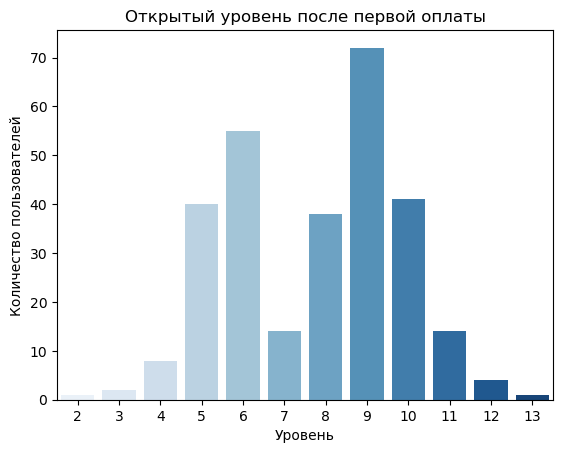

In [29]:
# посчитаю, какой уровень был открыт после первой оплаты
pay_level_first = pay_level_raw.query('time > pay_time').groupby('user_id').agg(
    level=('level', 'min')).reset_index()

# график
bar_graph = pay_level_first.groupby('level').agg(count=('user_id', 'count'))

# график
ax = sns.barplot(y='count', x=bar_graph.index, data=bar_graph, palette="Blues")


plt.title('Открытый уровень после первой оплаты')
plt.xlabel('Уровень')
plt.ylabel('Количество пользователей')

plt.show()

Больше всего первых платежей было проведено перед открытием 9, 6, 10, 5 и 8 уровней. Почти нет трат перед начальными уровнями и седьмым.

### Выводы

Анализ активности пользователей в обучающем игровом приложении с 11 по 30 мая 2023 года. Отчетный период с 12 по 30 мая.

В ходе подготовки была проведена предобработка: проверка явных и неявных дубликатов, смена формата данных.

Удержание платящих пользователей заметно выше, в первый день после регистрации возвращаются около 80%, на на 9 день - остается 43%. Неплатящие уступают - показатель удержания равномерно падает с 35% до 15% за первые 10 дней с момента регистрации. Для улучшения данной метрики предлагаю:
- <i> показывать при включении, сколько дней подряд ученик заходит в приложение (может быть, даже поощрения за внутреннюю валюту); </i>
- <i> добавить соревнования между друзьями;</i>
- <i> чаще напоминать об обучении (уведомления из приложения, письма на почту), но не навязчиво.</i>

Среднее время сессии составляет 7 минут, что мало для образовательного приложения, верхней границей считается показатель в полчаса, почти все сессии не превышают 1 часа 14 минут. Всего в приложении ученики проводят в среднем 1 час 12 минут, верхняя граница доходит до 3:27.

Доля пользователей, переходящих на следующий уровень снижается с 82% до 30% по мере увеличения уровня с 1 до 17.

Обычно уровни со 1 по 4 проходят в день регистрации, с 5 по 7 - на следующий день, а на второй день после регистрации доходят до уровня 9. Уровень 10 - 4 дня после регистрации, ур.11 - 6 дней, ур.12 - 7 дней, последующие уровни более недели. Есть пользователи, открывшие второй уровень только на 10 день после регистрации, а есть те, кто доходит до 12-14 уровня в день регистрации. Пользователи, поднявшиеся выше 15 уровня, потратили на это чуть больше недели.

Монетизация:
- <i> доход сервиса за период составил 501,41
- <i> из 31 114 зарегистрованных пользователей совершали оплату 312 (более 1%, что является низким показателем)
- <i> доход на пользователя составил 0,02; на платящего - 1,61
- <i> средний чек равен 0,40
- <i> каждый третий платящий пользователь совершил более одной покупки (115 человек)
- <i> количество ежедневно платящих пользователей сокращается наряду с падением посещений сервиса

Чаще всего пользователи платят перед переходом на уровни 9, 10, 11 и 6. После 12 - идет спад, обусловленный снижающейся активностью пользователей. Также мало платят перед первыми уровнями (до 5). Мало тратят и для открытия 7 уровня, который является самым доступным (95% пользователей 6 уровня открыли 7) - это означает, что задание уровня 6 достаточно простые. Больше всего первых платежей было проведено перед получением 9, 6, 10, 5 и 8 уровней. Почти нет трат перед начальными уровнями и седьмым.

В первую очередь, нужно отслеживать удержание пользователей по дням, принять меры для увеличения, а также мониторить ARPU и ARPPU. Еще важный специфичный для данного кейса показатель - прохождение уровней: чем дальше пользователь проходит, тем он более лоялен (чаще заходит, больше платит, готов пройти другие курсы).

Я бы посоветовал учитывать стоимость привлечения пользователей (CAC) в сравнении со средним доходом. Для этого нужны расходы на рекламу.

Еще бы разделил на когорты по дням регистрации, чтобы оценивать путь клиента по каждому дню обучения.

Также стоит посмотреть, как люди переходят на смежные программы приложения, чтобы оценить, насколько им подходят конкретные курсы (в целом тоже интересно было бы посмотреть аудитории разных курсов и сравнить их метрики).

Также можно добавить параметры учеников приложения (гендер, возраст, занятость), чтобы определить целевую аудиторию для более высокого удержания текущих пользователей и привлечения новых.

Еще можно добавить метрики игровой и обучающей индустрий, например, удовлетворенность приложением.